In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# Dùng thư viện yfinance để tải dataset 
import yfinance as yf

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
import math

In [ ]:
df = pd.read_csv('BTC-USD.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/1/2019,3746.713379,3850.913818,3707.231201,3843.520020,3843.520020,4.324201e+09
1,1/2/2019,3849.216309,3947.981201,3817.409424,3943.409424,3943.409424,5.244857e+09
2,1/3/2019,3931.048584,3935.685059,3826.222900,3836.741211,3836.741211,4.530215e+09
3,1/4/2019,3832.040039,3865.934570,3783.853760,3857.717529,3857.717529,4.847965e+09
4,1/5/2019,3851.973877,3904.903076,3836.900146,3845.194580,3845.194580,5.137610e+09


**<h3>ARIMA 6-3-1</h3>**

In [ ]:
df = df[['Date', 'Close']]
df = df.dropna() # Drop missing values
# df = df.reset_index(drop=True) # Reset the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]
print(df)

                   Close
Date                    
2019-01-01   3843.520020
2019-01-02   3943.409424
2019-01-03   3836.741211
2019-01-04   3857.717529
2019-01-05   3845.194580
...                  ...
2023-03-27  27139.888670
2023-03-28  27268.130860
2023-03-29  28348.441410
2023-03-30  28033.562500
2023-03-31  28478.484380

[1551 rows x 1 columns]


In [ ]:
print(len(df))
print(len(train_data))
print(train_size)

1551
930
930


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.9 MB/s eta 0:00:00


In [ ]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15463.160, Time=1.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15470.836, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15465.152, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15466.259, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15469.681, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15461.203, Time=0.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15461.041, Time=0.17 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15461.745, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15464.148, Time=0.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15463.203, Time=2.16 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=15459.907, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15465.258, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=15459.475, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15463.029, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [ ]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
print(last_index)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days)) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
[31734.63145358 31749.49057604 31757.26269679 31761.32793422
 31763.45427219 31764.56646138 31765.14819618 31765.45247479
 31765.61162888 31765.69487503 31765.73841725 31765.76119218
 31765.77310469 31765.77933557 31765.78259466 31765.78429934
 31765.78519098 31765.78565735 31765.78590129 31765.78602888
 31765.78609562 31765.78613053 31765.78

In [ ]:
# 12. Đánh giá độ chính xác thuật toán
import sklearn.metrics as metrics
mae = mean_absolute_error(y_test,y_pred)
print('MAE:', mae)

MAE: 12647.340086314523


In [ ]:
mse = mean_squared_error(y_test,y_pred)
print('MSE:', mse)

MSE: 213188376.5699898


In [ ]:
rmse = math.sqrt(mean_squared_error(y_test,y_pred))
print('RMSE:', rmse)

RMSE: 14600.971768001944


In [ ]:
r2 = r2_score(y_test, y_pred)
print('r2:', r2)

r2: -0.19967794073174527


In [ ]:
def mape(y_test, pred):
    y_test, pred = np.array(y_test), np.array(pred)
    mape = np.mean(np.abs((y_test - pred) / y_test))
    return mape
mape = mape(y_test, y_pred)
print('MAPE:', mape)

MAPE: 0.3489605704722312


Validation RMSE: 11742.173228163549
Testing RMSE: 14600.971768001944
Validation MAPE: 0.5891573889301528
Testing MAPE: 0.3489605704722312


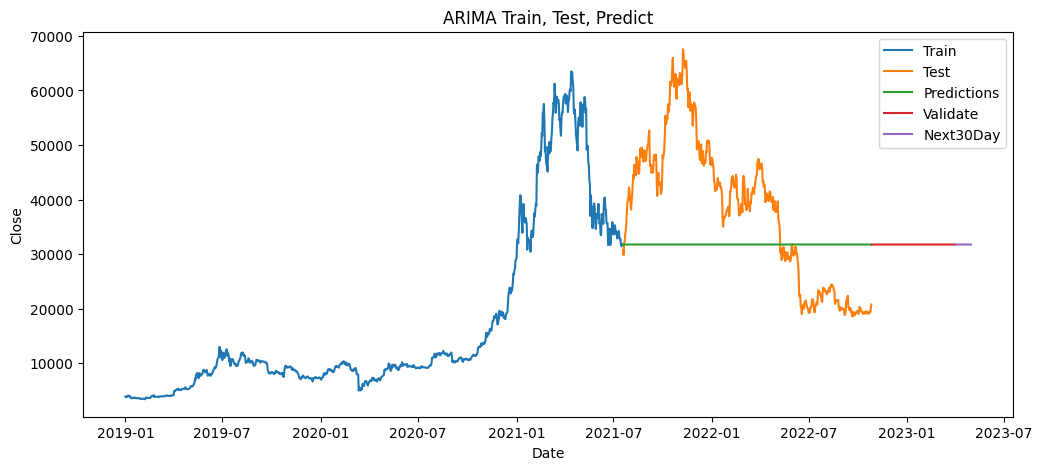

In [ ]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMA Train, Test, Predict')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index,y_next_30_days)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()